## 0.0 Imports

In [1]:
!pip install boruta

In [1]:
import inflection
import math
import datetime
import random
import warnings
import pickle
import json
import requests

import pandas            as pd
import numpy             as np
import seaborn           as sns
import xgboost           as xgb

from scipy      import stats  as ss
from matplotlib import pyplot as plt

from tabulate              import tabulate
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from boruta                import BorutaPy
from flask                 import Flask, request, Response

warnings.filterwarnings('ignore')

### 0.1 Loading data

In [5]:
df_sales_raw = pd.read_csv('C:/Users/gabri/Repos/Rossmann-Store-Sales/Date/train.csv',low_memory = False)
df_store_raw = pd.read_csv('C:/Users/gabri/Repos/Rossmann-Store-Sales/Date/store.csv',low_memory = False)

#merge

df_raw = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

In [4]:
df_raw.sample().T

,995942
Store,1033
DayOfWeek,7
Date,2013-01-20
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,a


### 0.2 Help functions

In [5]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( ( chi2corr / n ) / (min ( kcorr - 1, rcorr - 1 ) ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model name': model_name,
                           'MAE':mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index = [0] )

def cross_validation( x_training, kfold, model_name, model, verbose = False ):

#start and end date for validation
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( kfold + 1 ) ):
        if verbose:
            print( '\nKFold number: {}'.format( k ) )
            validation_start_date = x_training[ 'date' ].max() - datetime.timedelta( days = k*6*7 )
            validation_end_date = x_training[ 'date' ].max() - datetime.timedelta( days = (k-1)*6*7 )

#filtering dataset

            training = x_training[x_training['date'] < validation_start_date]
            validation = x_training[(x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date )]


#training and validation dataset

            xtraining = training.drop( ['date','sales'], axis = 1 )
            ytraining = training['sales']

            xvalidation = validation.drop( ['date','sales'], axis = 1 )
            yvalidation = validation['sales']

#model

            m = model.fit( xtraining, ytraining )

#prediction

            yhat = m.predict( xvalidation )

#performance

            m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

#store performance of each kfold iteration

            mae_list.append( m_result['MAE'] )
            mape_list.append( m_result['MAPE'] )
            rmse_list.append( m_result['RMSE'] )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )



## 1.0 Description data

In [6]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# Ponto de estudo!

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))

df1.columns = cols_new

### 1.2 Dimensions

In [9]:
print('number of rows:{}'.format(df1.shape[0]))
print('number of cols:{}'.format(df1.shape[1]))

number of rows:1017209
number of cols:18


### 1.3 Data types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NAN

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [12]:
#competition_distance
# Ponto de estudo

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis = 1)

#promo2_since_week
                                               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis = 1)

#promo2_since_year                                      
 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis = 1)

#promo_interval

month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0,inplace = True)

#ponto de estudo - função map

df1['month_map'] = df1['date'].dt.month.map(month_map)

#ponto de estudo - função split

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis = 1)

df1.isna().sum().T

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Change types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
#competition_open_since_month

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)

#competition_open_since_year

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

#promo2_since_week

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)

#promo2_since_year

df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

### 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

#### 1.7.1 Numerical attributes

In [16]:
#central tendency - mean and median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T

ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion tendency - max, min, range, std, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T

d2 = pd.DataFrame(num_attributes.apply(max)).T

d3 = pd.DataFrame(num_attributes.apply(min)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T

d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['Features','Max','Min','Range','Mean','Median','Std','Skew','Kurtosis']
m

,Features,Max,Min,Range,Mean,Median,Std,Skew,Kurtosis
0,store,1115.0,1.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,7.0,1.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,41551.0,0.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,7388.0,0.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,1.0,0.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,1.0,0.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,1.0,0.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,200000.0,20.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,12.0,1.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2015.0,1900.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### 1.7.2 Categorical attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

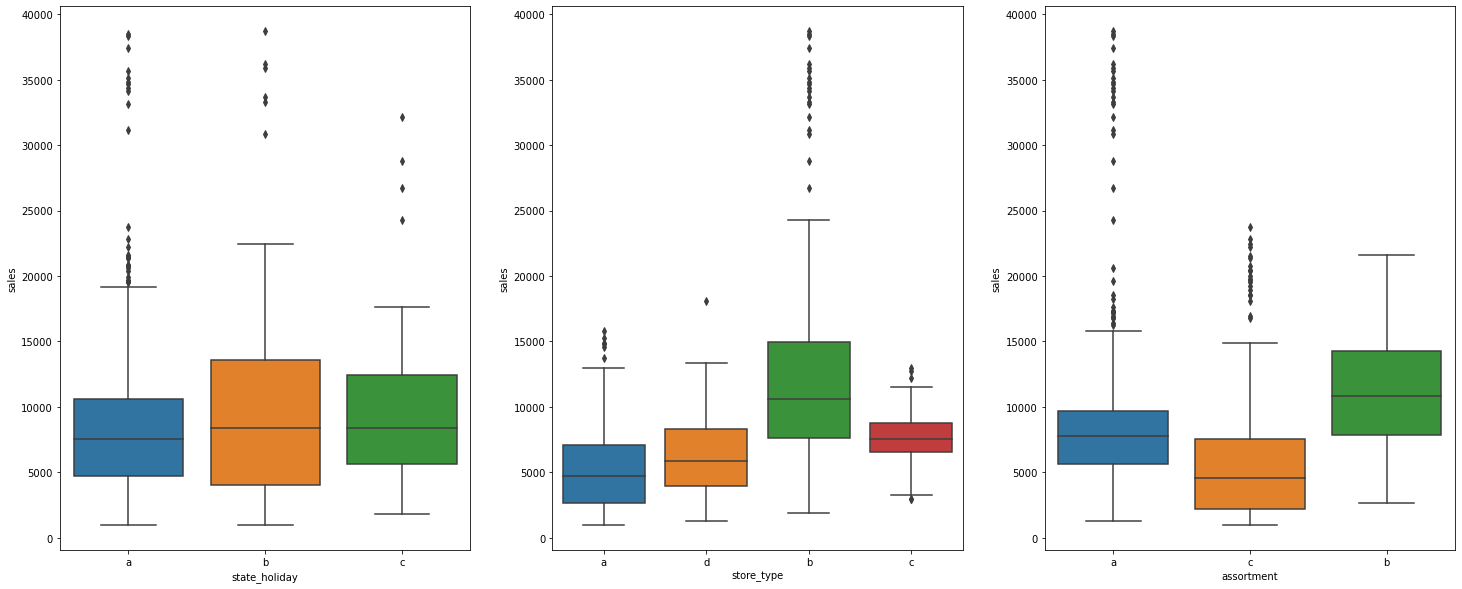

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize = (25,10))

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday',y = 'sales',data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type',y = 'sales',data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment',y = 'sales',data = aux1)

## 2.0 Mind Map

In [19]:
df2 = df1.copy()

### 2.1 Hypotesis creation

#### 2.1.1 Store hypotesis

**1.** Lojas com maior quadro de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor estoque deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores a mais tempo deveriam vender mais.

#### 2.1.2 Product hypotesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais.

**5.** Lojas com promoções ativa por mais tempo deveriam vender mais.

**6.** Lojas com mais dia de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.1.3 Time hypotesis

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 06 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas abertas durante o feriado de natal deveriam vender mais.

**5.** Lojas deveriam vender mais ao longo dos anos.

**6.** Lojas devriam vender mais no segundo semestre do ano.

**7.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**8.** Lojas deveriam vender menos aos finais de semana.

**9.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2 Final hypotesis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativa por mais tempo deveriam vender mais.

**5.** Lojas com mais dia de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas devriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Feature engineering

In [20]:
#year
df2['year'] = df2['date'].dt.year

#month

df2['month'] = df2['date'].dt.month

#day

df2['day'] = df2['date'].dt.day

#week of year

df2['weak_of_year'] = df2['date'].dt.weekofyear

#year week

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days ).astype( np.int64 )

#promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply( lambda x:datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7).apply(lambda x: x.days).astype(np.int64)

#assortment

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular day')

## 3.0 Filtering variables

In [21]:
df3 = df2.copy()

### 3.1 Filtering rows

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Selection columns

In [23]:
cols_drop = ['customers','open','promo_interval','month_map']

df3 = df3.drop(cols_drop,axis=1)

In [24]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'weak_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0 EDA - Exploratory Data Analysis

In [25]:
df4 = df3.copy()

### 4.1 Uni analysis

#### 4.1.1 Response variable

<AxesSubplot:xlabel='sales'>

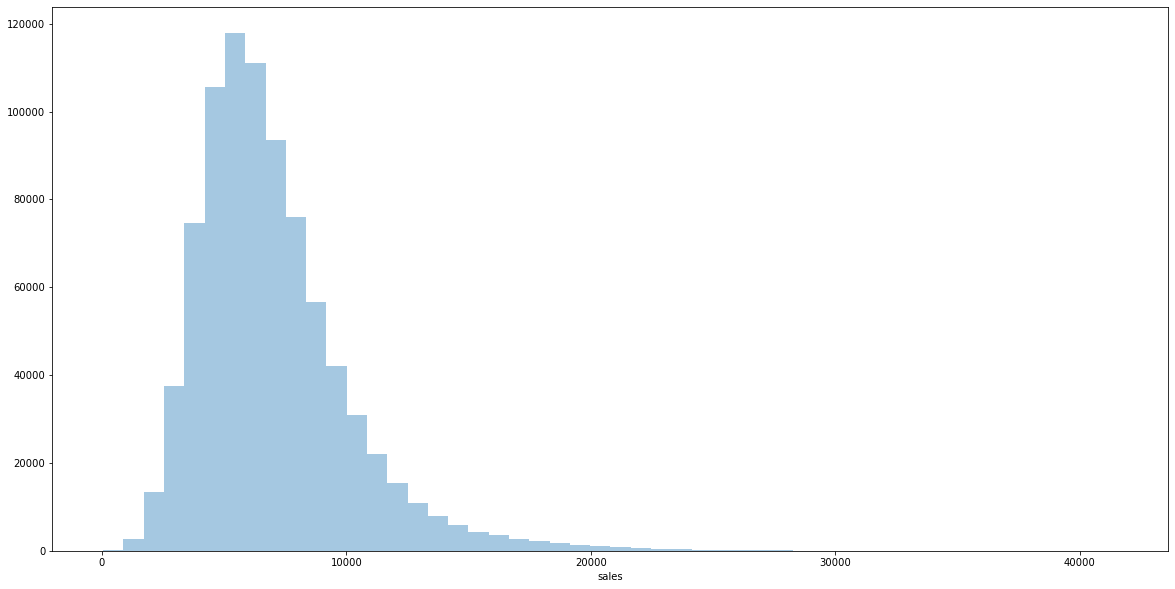

In [26]:
plt.figure(figsize = (20,10))
sns.distplot(df4['sales'], kde = False)

#### 4.1.2 Numerical variable

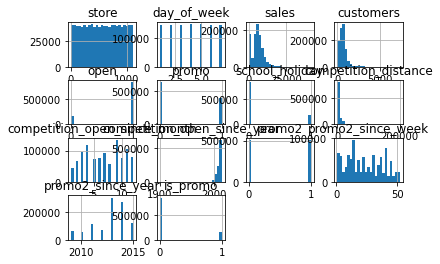

In [27]:
num_attributes.hist( bins = 25 );

#### 4.1.3 Categorical variable

In [28]:
df4['assortment'].drop_duplicates().head()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

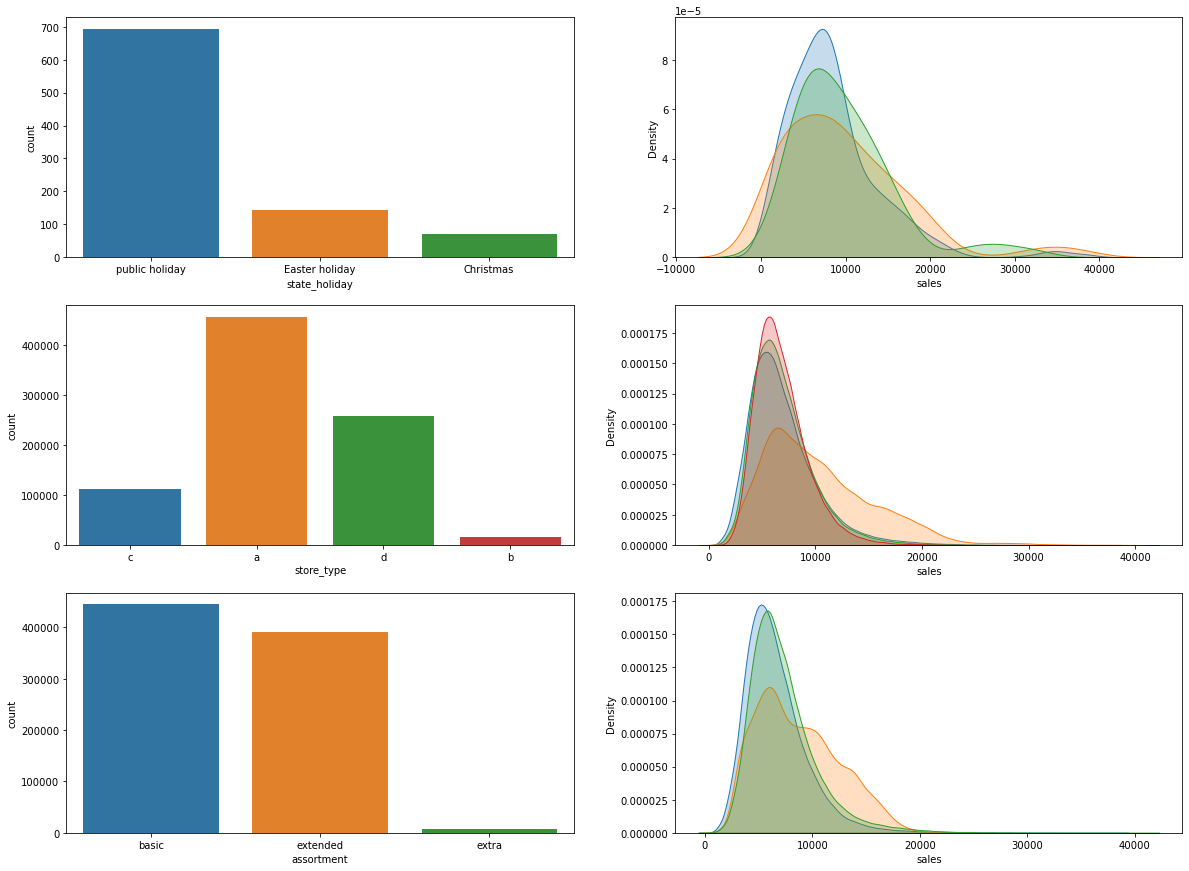

In [29]:
#state holiday

plt.figure(figsize=(20,15))

plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular day']
sns.countplot(a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public holiday']['sales'], label = 'public holiday', shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'Easter holiday']['sales'], label = 'Easter holiday', shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'Christmas']['sales'], label = 'Christmas', shade = True )

#store_type

plt.subplot( 3, 2, 3 )
sns.countplot(df4['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True )

#assortment

plt.subplot( 3, 2, 5 )
sns.countplot(df4['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True )


### 4.2 Bi analysis

#### H1. Lojas com maior sortimento deveriam vender mais.
***False*** Lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='year_week'>

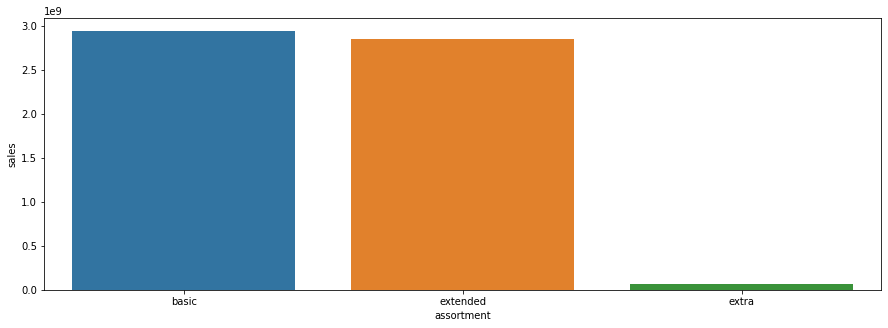

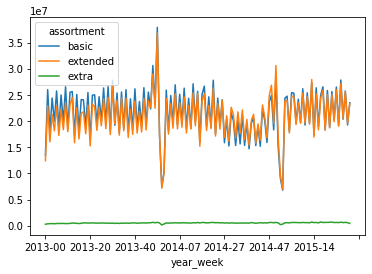

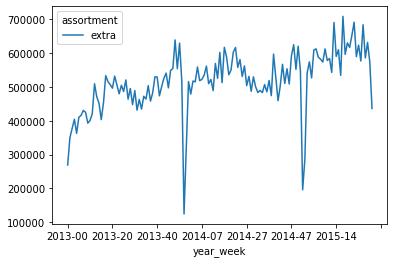

In [30]:
plt.figure(figsize = (15,5))

aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment',y = 'sales', data = aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales' ).plot()

#### H2 Lojas com competidores mais próximos deveriam vender menos.
**False** Lojas com competidores mais próximos vendem mais

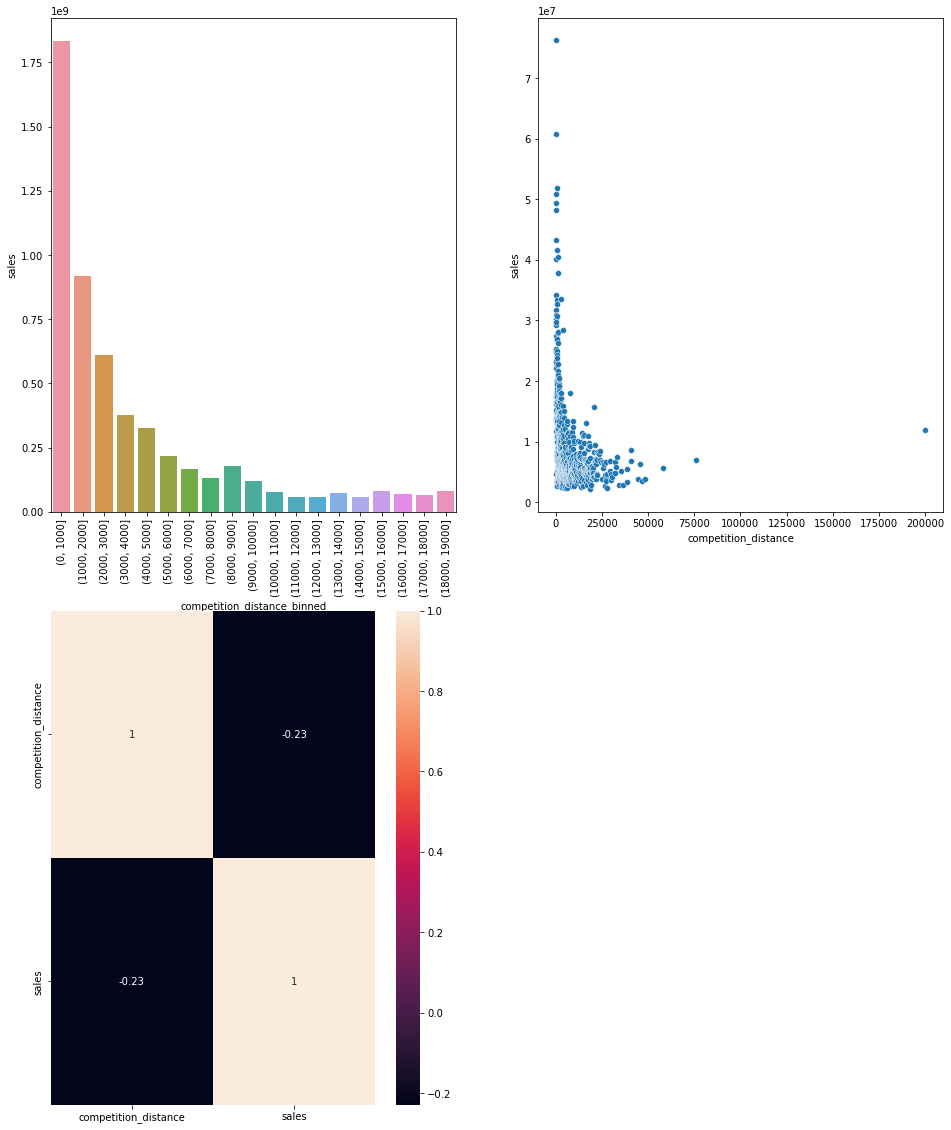

In [31]:
plt.figure(figsize = ( 16 , 20 ) )

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list( np.arange( 0, 20000, 1000 ) )

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins = bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'competition_distance_binned',y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(2,2,2)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H3 Lojas com competidores a mais tempo deveriam vender mais.
**False** Lojas com competidores há mais tempo vendem menos

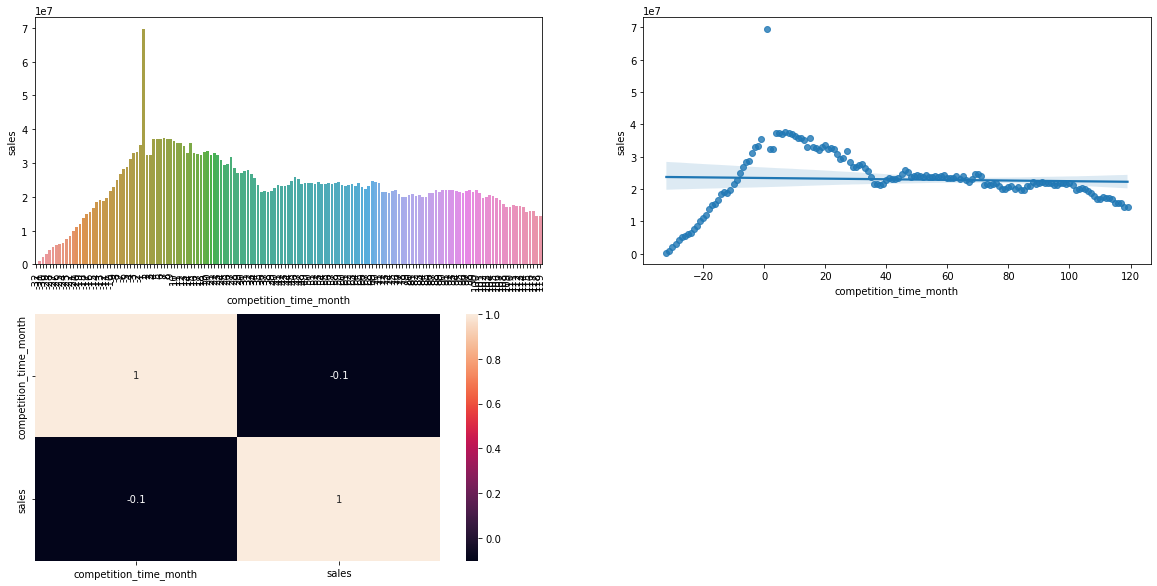

In [32]:
plt.figure( figsize = ( 20, 10 ) )

aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]

plt.subplot(2,2,1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(2,2,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'),annot = True);

#### H4: Lojas com promoções ativa por mais tempo deveriam vender mais.
**False** Lojas com promoções ativa por mais tempo vendem menos

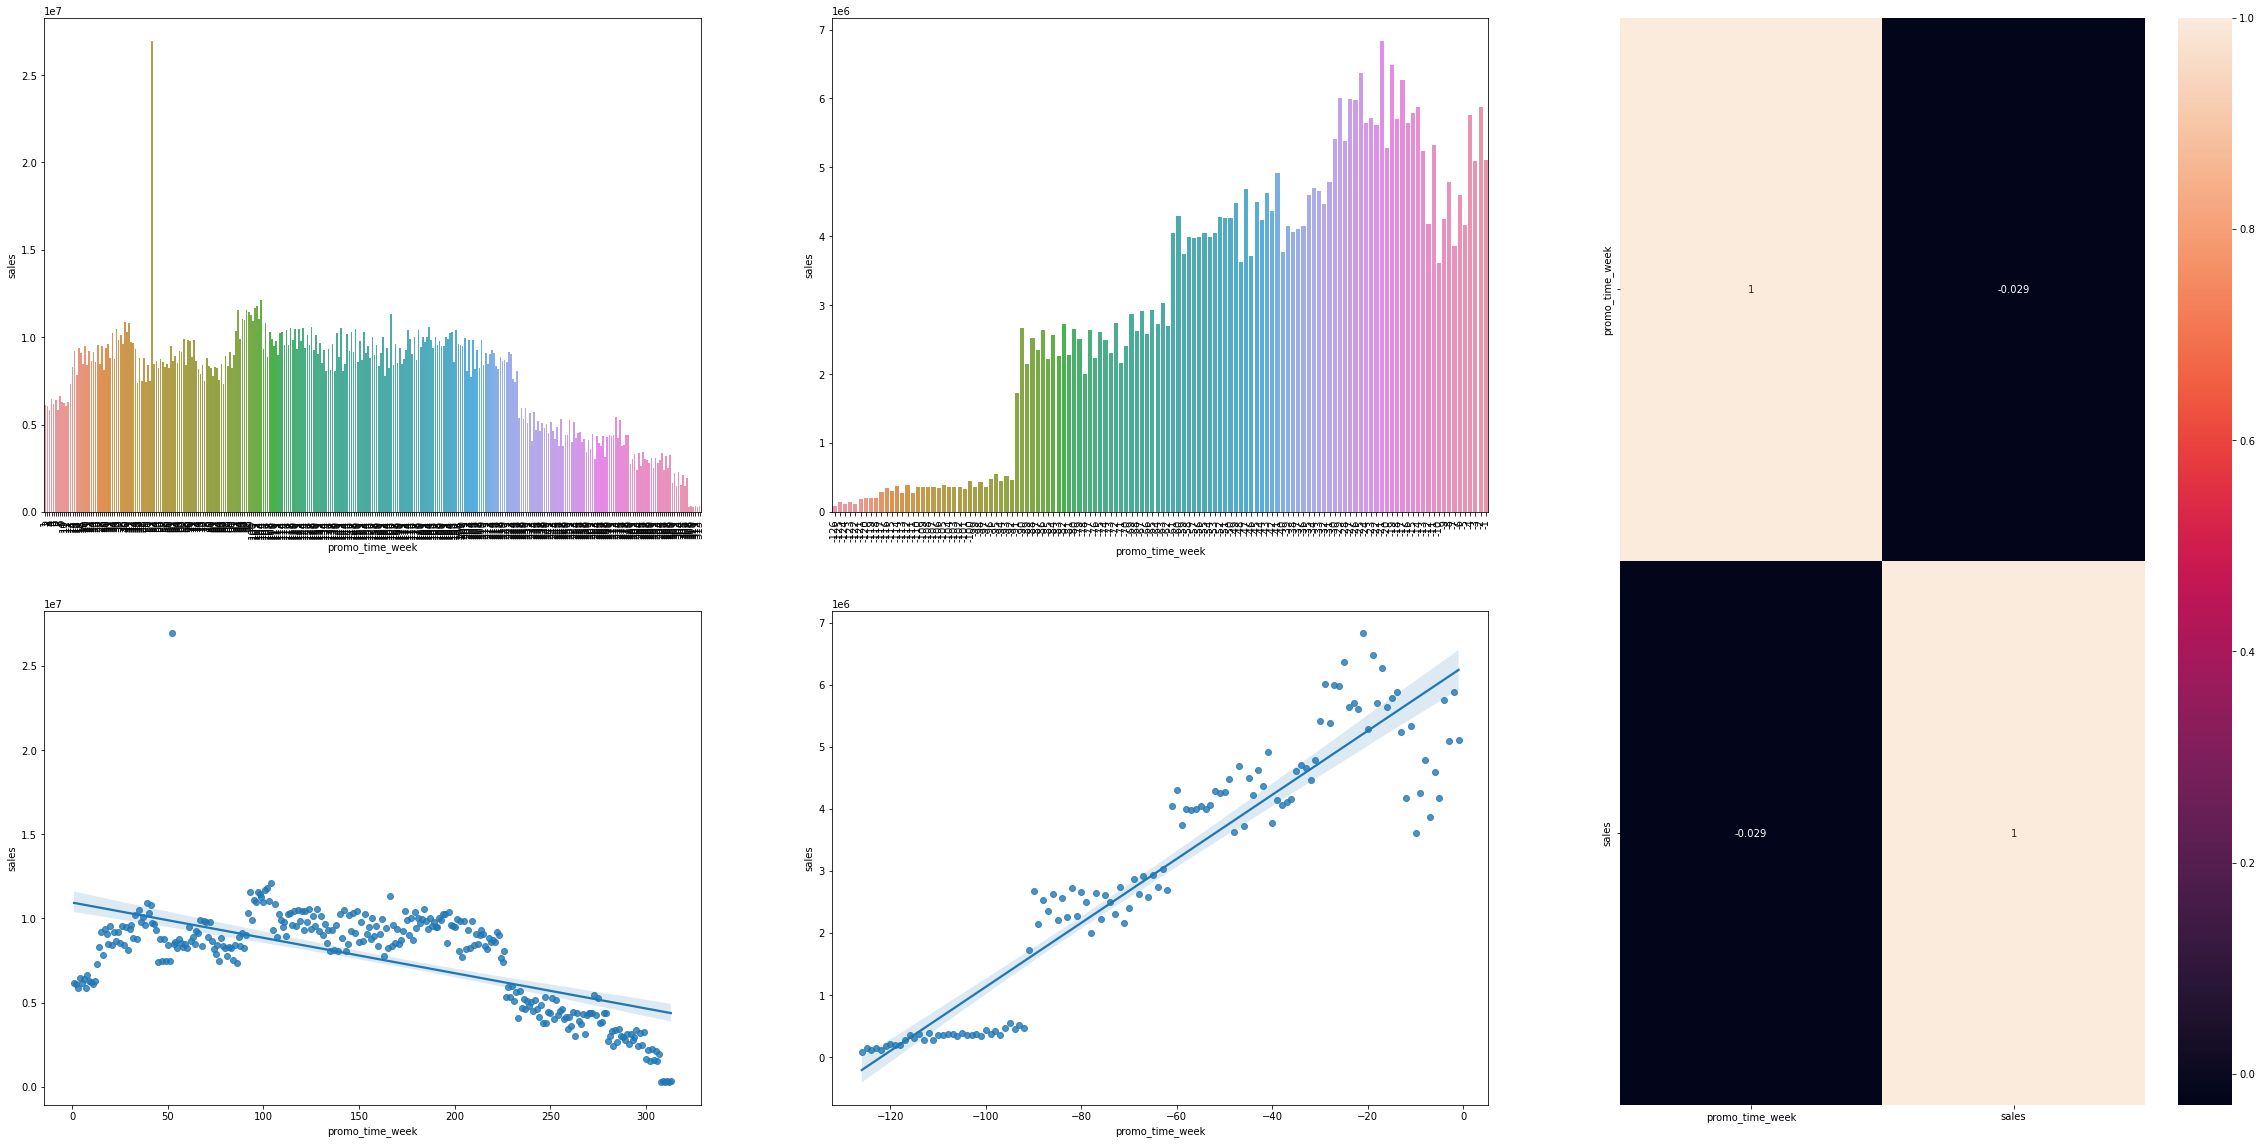

In [33]:
plt.figure(figsize = ( 40, 20 ) )

grid = plt.GridSpec( 2, 3 )

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

#sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular

plt.subplot(grid[0,0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);


plt.subplot(grid[0,1])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,0])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


#### <s/> H5: Lojas com mais dia de promoção deveriam vender mais.</s>

#### H6: Lojas com mais promoções consecutivas deveriam vender mais.
**False** Lojas com mais promoções consecutivas vendem menos

In [34]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


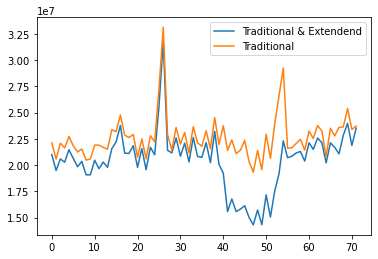

In [35]:
aux1 = df4[(df4['promo'] == 1) &(df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) &(df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax);

ax.legend(labels = ['Traditional & Extendend', 'Traditional']);

#### H7 Lojas abertas durante o feriado de natal deveriam vender mais.
**False** Lojas durante o feriado do natal vendem menos

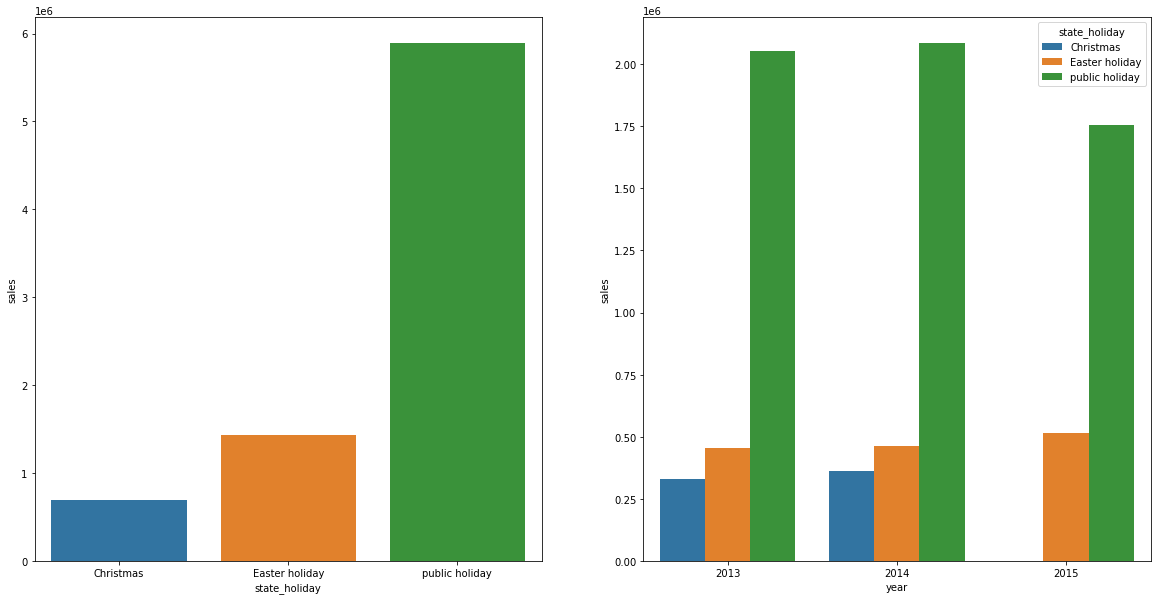

In [36]:
plt.figure(figsize = (20,10))

aux = df4[df4['state_holiday'] != 'regular day']
plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);


#### H8 Lojas deveriam vender mais ao longo dos anos.
**False** Lojas estão vendendo menos ao longo dos anos

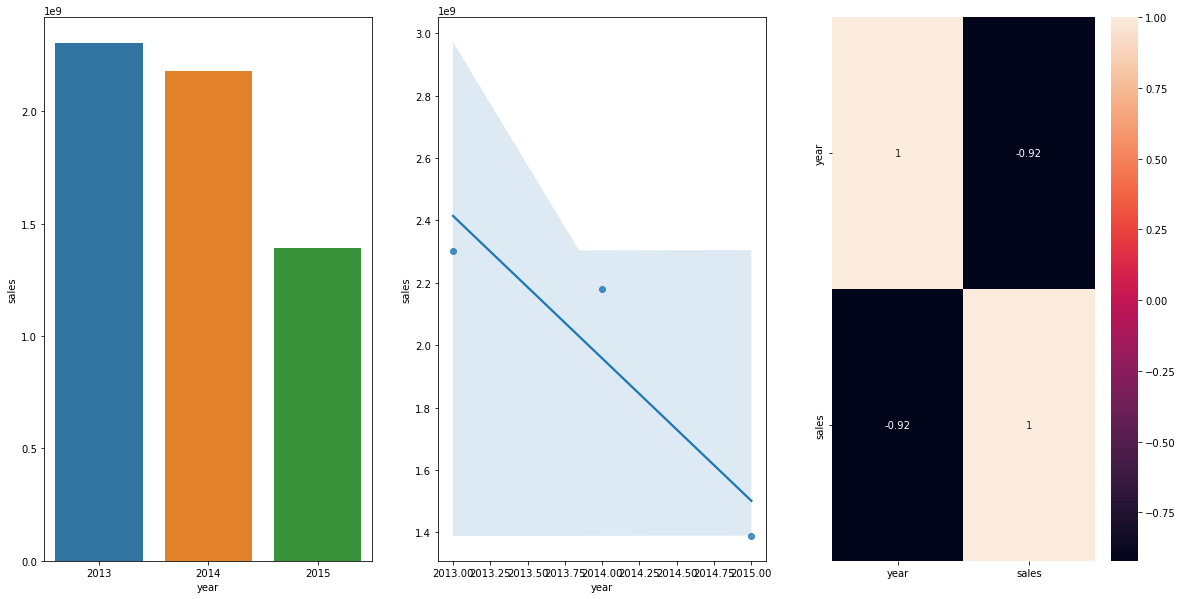

In [37]:
plt.figure(figsize = (20,10))

aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H9 Lojas devriam vender mais no segundo semestre do ano.
**False** Lojas vendem menos no segundo semetre do ano

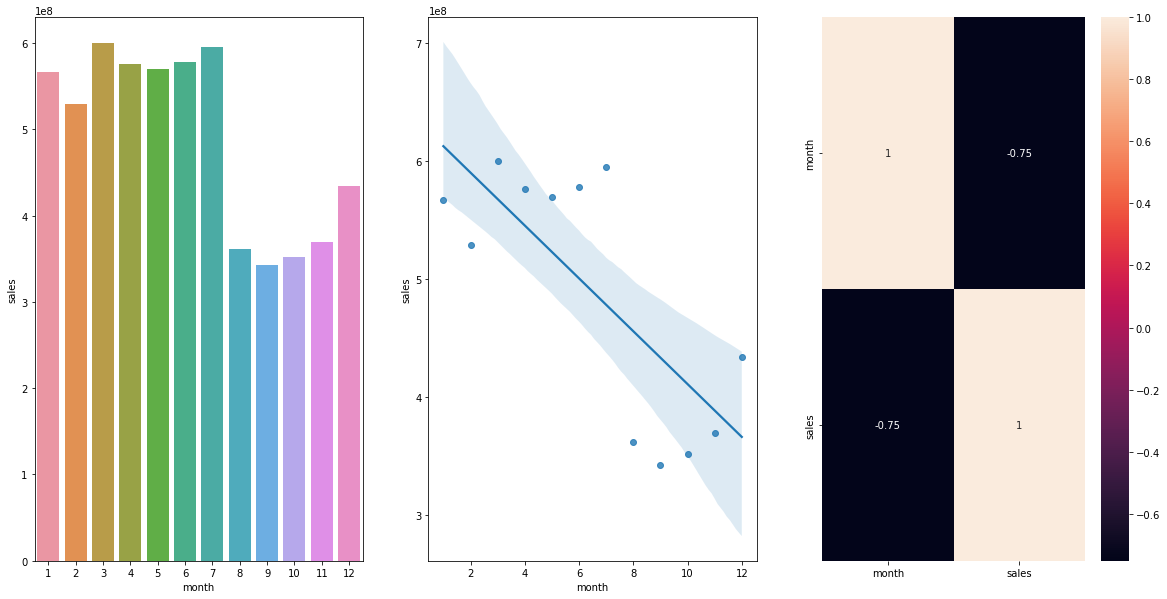

In [38]:
plt.figure(figsize = (20,10))

aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H10 Lojas deveriam vender mais depois do dia 10 de cada mês.
**True** Lojas vendem mais depois do dia 10 de cada mês

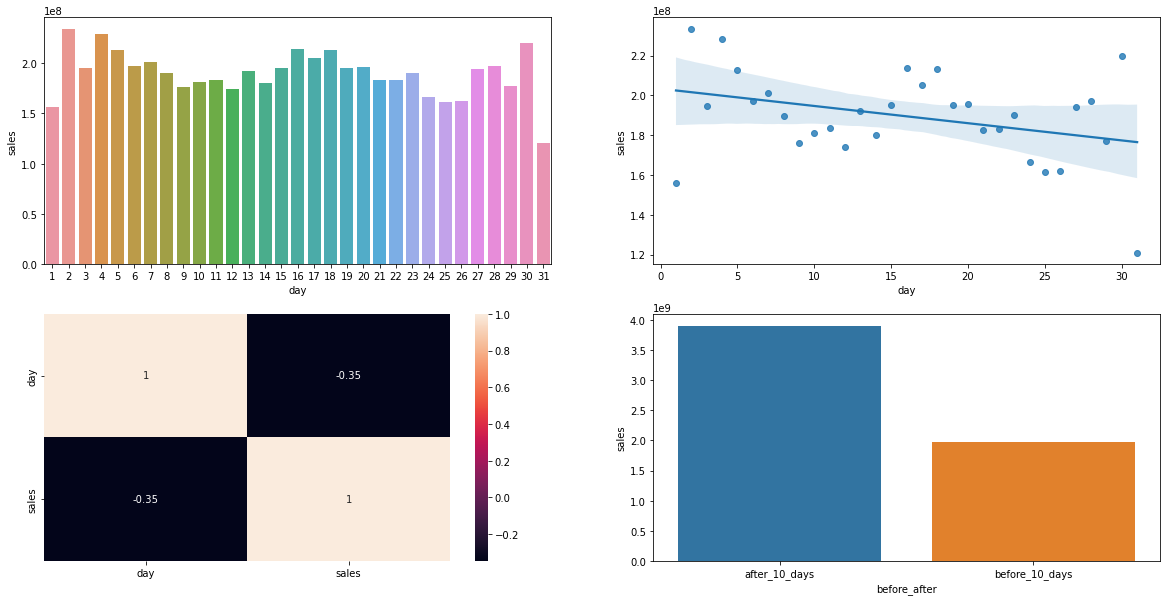

In [39]:
plt.figure(figsize = (20,10))

aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot(2,2,4)
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);


#### H11 Lojas deveriam vender menos aos finais de semana.
**True** Lojas vendem menos aos fins de semana

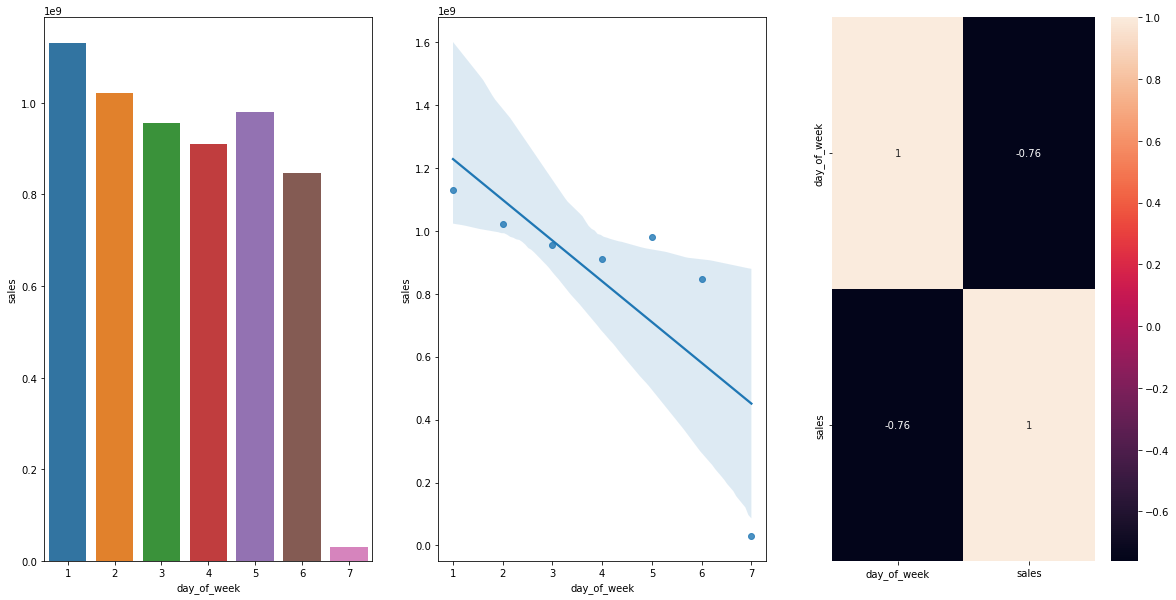

In [40]:
plt.figure(figsize = (20,10))

aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

#### H12 Lojas deveriam vender menos durante os feriados escolares.
**True** Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto

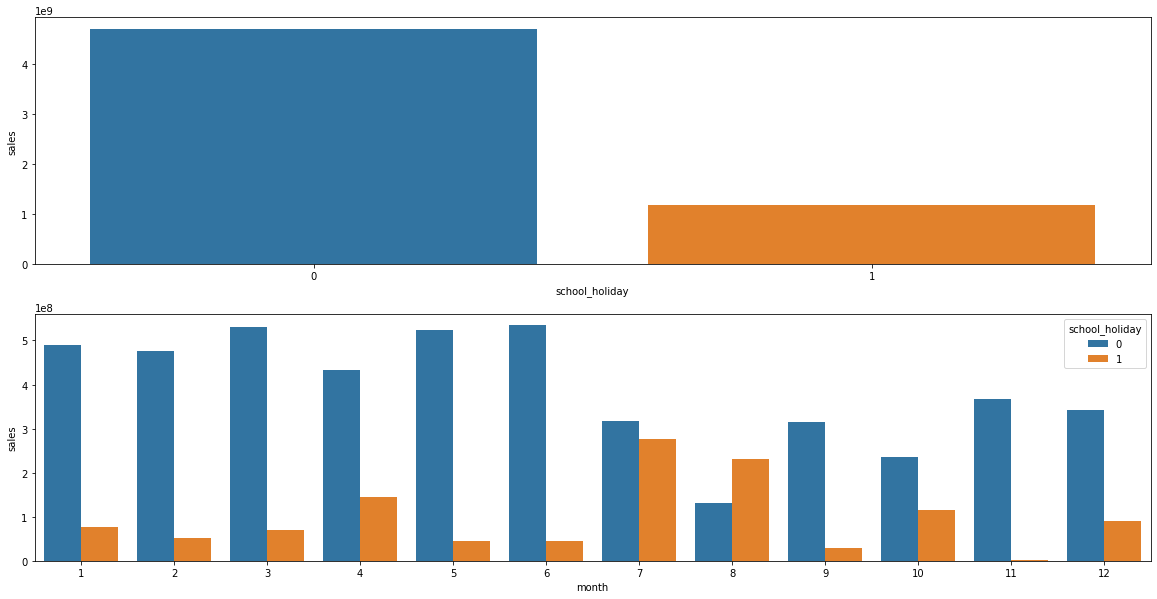

In [41]:
plt.figure(figsize = (20,10))

aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

### 4.2.1 Hypotesis resume

In [42]:
tab = [['Hipóteses','Conclusão','Relevância'],
      ['H1','Falsa', 'Baixa'],
      ['H2','Falsa', 'Média'],
      ['H3','Falsa', 'Baixa'],
      ['H4','Falsa', 'Média'],
      ['H5','-', '-'],
      ['H6','Falsa', 'Baixa'],
      ['H7','Falsa', 'Média'],
      ['H8','Falsa', 'Alta'],
      ['H9','Falsa', 'Alta'],
      ['H10','Verdadeira', 'Alta'],
      ['H11','Verdadeira', 'Alta'],
      ['H12','Verdadeira', 'Baixa']]

print( tabulate ( tab, headers = 'firstrow' ) )


Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Baixa
H4           Falsa        Média
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### 4.3 Multi analysis

#### 4.3.1 Numerical attributes

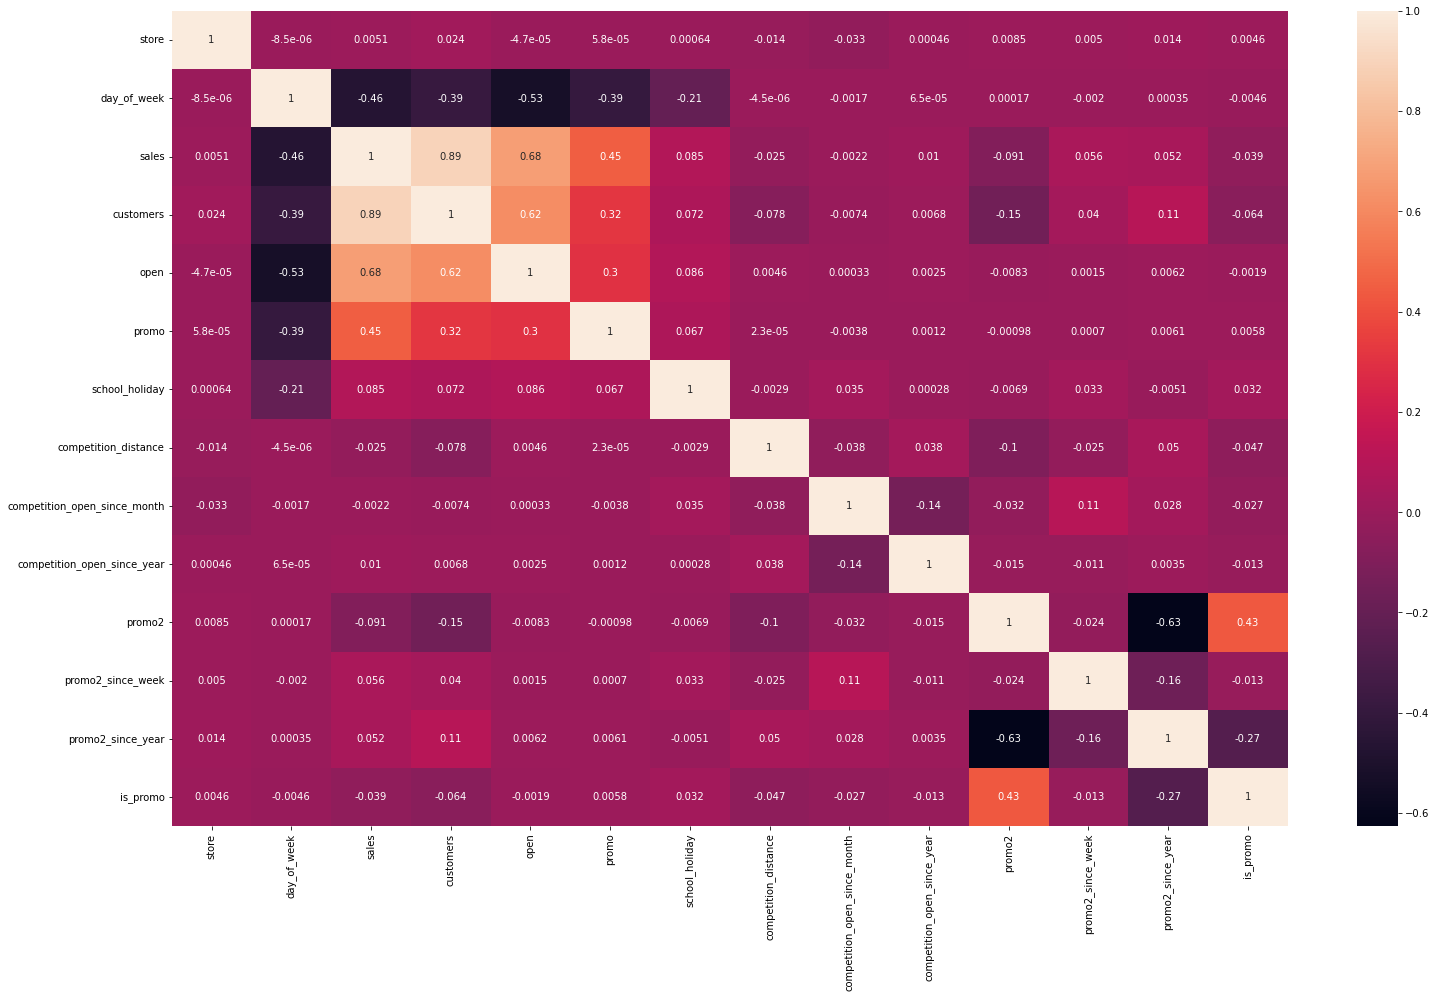

In [43]:
plt.figure(figsize = (25,15))

corr = num_attributes.corr(method = 'pearson')
sns.heatmap(corr,annot = True);

#### 4.3.2 Categorical attributes

In [44]:
#dataset categorical attributes
a = df4.select_dtypes(include = 'object')
cm = pd.crosstab( a['state_holiday'], a['store_type'] ).values

#calculate cramer V
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

#Final datset
d = pd.DataFrame( {'state_holiday': [a1,a2,a3], 
               'store_type': [a4,a5,a6], 
               'assortment': [a7,a8,a9] })

d = d.set_index(d.columns)

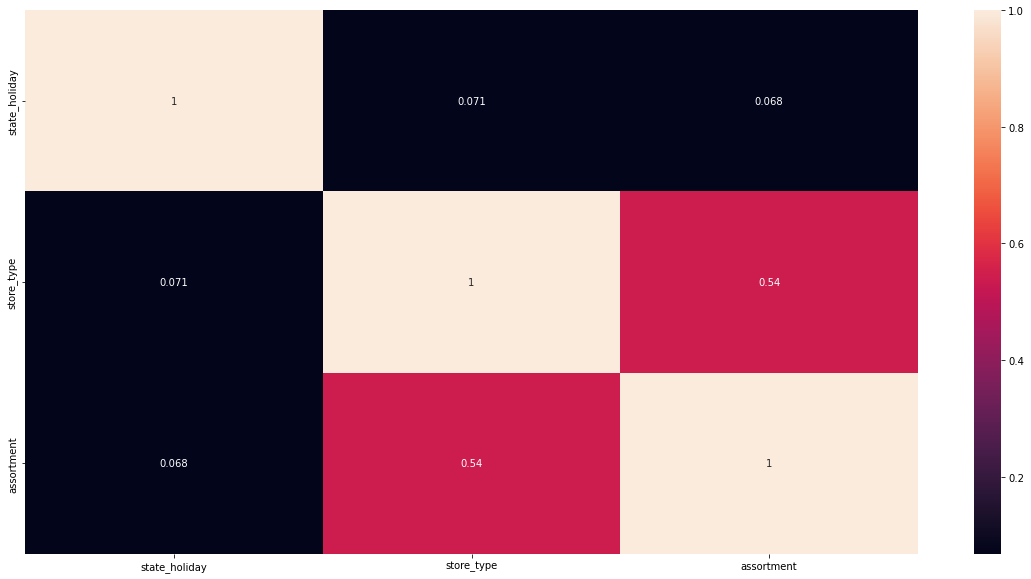

In [45]:
plt.figure(figsize = (20,10) )
sns.heatmap(d, annot = True);

## 5.0 Data preparation

In [46]:
df5 = df4.copy()

### 5.1 Normalização

### 5.2 Rescaling

In [47]:
a = df5.select_dtypes( include = ['int64','float64'] )

In [48]:
a.head().T

,0,1,2,3,4
store,1.0,2.0,3.0,4.0,5.0
day_of_week,5.0,5.0,5.0,5.0,5.0
sales,5263.0,6064.0,8314.0,13995.0,4822.0
promo,1.0,1.0,1.0,1.0,1.0
school_holiday,1.0,1.0,1.0,1.0,1.0
competition_distance,1270.0,570.0,14130.0,620.0,29910.0
competition_open_since_month,9.0,11.0,12.0,9.0,4.0
competition_open_since_year,2008.0,2007.0,2006.0,2009.0,2015.0
promo2,0.0,1.0,1.0,0.0,0.0
promo2_since_week,31.0,13.0,14.0,31.0,31.0


In [49]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance

df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/competition_distance_scaler.pkl', 'wb' ) )

#year

df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/year_scaler.pkl', 'wb' ) )


#competition_time_month

df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/competition_time_month_scaler.pkl', 'wb' ) )


#promo_time_week

df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/promo_time_week_scaler.pkl', 'wb' ) )


### 5.3 Transformação

#### 5.3.1 Encoding

In [50]:
#state_holiday - One Hot Encoding

df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

#store_type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/store_type_scaler.pkl', 'wb' ) )

#assortment - Ordinal Encoding

assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2 Response variable transformation

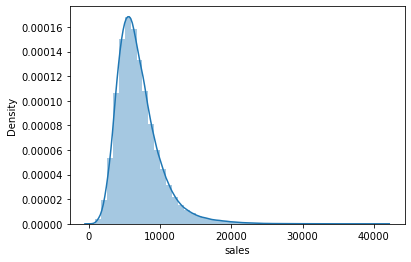

In [51]:
sns.distplot(df5['sales']);

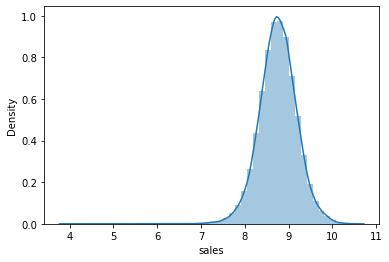

In [52]:
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot(df5['sales']);

#### 5.3.3 Nature transformation

In [53]:
#day_of_week

df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2 * np.pi/12 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2 * np.pi/12 ) ) )

#month

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2 * np.pi/12 ) ) )

#day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2 * np.pi/30 ) ) )

#week_of_year

df5['week_of_year_sin'] = df5['weak_of_year'].apply(lambda x: np.sin(x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['weak_of_year'].apply(lambda x: np.cos(x * ( 2 * np.pi/52 ) ) )

## 6.0 Feature selection

In [54]:
df6 = df5.copy()

### 6.1 Split dataframe into training and test

In [55]:
df6.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,8.568646,8.71029,9.025816,9.546527,8.481151
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.903226,-0.275806,4.448387
competition_open_since_month,9,11,12,9,4


In [56]:
cols_drop = ['weak_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop( cols_drop, axis = 1 )

In [57]:
#data min = 2013-01-02
#data max = 2015-07-31

df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 7*6 )

Timestamp('2015-06-19 00:00:00')

In [58]:
#Train dataset

x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#Test dataset

x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Traning min date: {}'.format( x_train['date'].min() ) )
print('Traning max date: {}'.format( x_train['date'].max() ) )

print('\nTest min date: {}'.format( x_test['date'].min() ) )
print('Test max date: {}'.format( x_test['date'].max() ) )

Traning min date: 2013-01-01 00:00:00
Traning max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


### 6.2 Boruta as feature selector

In [59]:
#Training and test dataset for boruta

x_train_n = x_train.drop( ['date','sales'], axis = 1).values
y_train_n = y_train.values.ravel()

In [60]:
#define RandomForestRegressor
rf = RandomForestRegressor( n_jobs = -1 )

In [61]:
#define Boruta

#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( x_train_n, y_train_n )

#### 6.2.1 Best features from Boruta

In [62]:
#cols_selected = boruta.support_.tolist()

#best features
#x_train_fs = x_train.drop( ['date','sales'], axis = 1 )
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected]

#not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

#cols_selected_boruta.columns

### 6.3 Manual Features Selection

In [63]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                              'competition_open_since_month', 'competition_open_since_year', 'promo2',
                              'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                              'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                              'day_sin', 'day_cos', 'week_of_year_cos','week_of_year_sin']

#columns to add

feat_to_add = ['date', 'sales']

#final features

#cols_selected_boruta_final.extend(feat_to_add)

#cols_selected_boruta_final

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 7.0 Machine Learning Model

In [64]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

#Times Series Data Preparation

x_training = x_train[cols_selected_boruta_full]

In [65]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

### 7.1 Average Model

In [66]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

#prediction

aux2 = aux1[[ 'sales','store' ]].groupby( 'store' ).mean().reset_index().rename( columns = {'sales':'predictions'} )
aux1 = pd.merge( aux1, aux2, how = 'left', on = 'store' )
yhat_baseline = aux1['predictions']

#performance

baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


### 7.2 Linear Regression Model

In [67]:
#model

lr = LinearRegression().fit( X_train, y_train )

#prediction

yhat_lr = lr.predict( X_test )

#performance

lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression,1861.907707,0.29159,2663.539547


### 7.2.1 Linear Regression Model - Cross Validation

In [68]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose = True )
lr_result_cv


KFold number: 5

KFold number: 4

KFold number: 3

KFold number: 2

KFold number: 1

KFold number: 0


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2033.36 +/- 289.16,0.3 +/- 0.02,2868.11 +/- 463.57


### 7.3 Linear Regression Regularized Model - Lasso

In [69]:
#model

lrr = LinearRegression().fit( X_train, y_train )

#prediction

yhat_lrr = lr.predict( X_test )

#performance

lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1861.976158,0.291692,2663.24407


### 7.3.1 Linear Regression Regularized Lasso Model - Cross Validation

In [70]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Lasso', lrr, verbose = True )
lrr_result_cv


KFold number: 5

KFold number: 4

KFold number: 3

KFold number: 2

KFold number: 1

KFold number: 0


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Lasso,2033.36 +/- 289.16,0.3 +/- 0.02,2868.11 +/- 463.57


### 7.4 Random Forest Regressor

In [71]:
#model

#rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42 ).fit( X_train, y_train )

#prediction

#yhat_rf = rf.predict( X_test )

#performance

#rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
#rf_result

### 7.4.1 Random Forest Regressor Model - Cross Validation

In [72]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose = True )
#rf_result_cv

### 7.5 XGBoost Regressor

In [73]:
#model

#model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              #n_estimators = 1000,
                              #eta = 0.01,
                              #max_depth = 10,
                              #subsample = 0.7,
                              #colsample_bytee = 0.9 ).fit( X_train, y_train )

#prediction

#yhat_xgb = model_xgb.predict( X_test )

#performance

#xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
#xgb_result

### 7.5.1 XGBoost Regressor Model - Cross Validation

In [74]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True )
#xgb_result_cv

### 7.6 Compare Model's Performance

#### 7.6.1 Compare Model's Single Performance

In [75]:
#modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
#modelling_result.sort_values( 'RMSE' )

#### 7.6.2 Compare Model's Real Performance

In [76]:
#modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
#modelling_result_cv.sort_values( 'RMSE CV' )

## 8.0 Hyperparameter Fine Tuning

### 8.1 Random Search

In [77]:
param = { 
           'n_estimators' : [ 1500, 1700, 2500, 3000, 3500 ],
           'eta': [ 0.01, 0.03 ],
           'max_depth': [ 3, 5, 9 ],
           'subsample': [ 0.1, 0.5, 0.7 ],
           'colsample_bytee': [ 0.3, 0.7, 0.9 ],
           'min_child_weight': [ 3, 8, 15 ] }
         
MAX_EVAL = 5

In [78]:
#final_result = pd.DataFrame()
#for i in range( MAX_EVAL):

# choose values for parameters randomly

    #hp = {k: random.sample( v , 1 )[0] for k, v in param.items() }
    #print(hp)
    
#model

    #model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              #n_estimators = hp['n_estimators'],
                              #eta = hp['eta'],
                              #max_depth = hp['max_depth'],
                              #subsample = hp['subsample'],
                              #colsample_bytee = hp['colsample_bytee'],
                              #min_child_weight = hp['min_child_weight'] )

#performance

    #result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True )
    #final_result = pd.concat( [ final_result, result ] )
    
#final_result

### 8.2 Final Model

In [79]:
param_tuned = { 
           'n_estimators' : 1700,
           'eta': 0.03,
           'max_depth': 9,
           'subsample': 0.1,
           'colsample_bytee': 0.9,
           'min_child_weight': 8 }

In [80]:
#model

model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = param_tuned['n_estimators'],
                              eta = param_tuned['eta'],
                              max_depth = param_tuned['max_depth'],
                              subsample = param_tuned['subsample'],
                              colsample_bytee = param_tuned['colsample_bytee'],
                              min_child_weight = param_tuned['min_child_weight'] ).fit( X_train, y_train )
    
#prediction

yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

#performance

result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )    
result_tuned

[09:17:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,640.850051,0.093433,940.512428


In [81]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.002947272225297844

In [168]:
#Save Trained Model

#pickle.dump( result_tuned, open ( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/model/model_rossmann.pkl', 'wb' ) )

pickle.dump(model_xgb_tuned, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/model/model_rossmann.pkl', 'wb' ) )

## 9.0 Translation and Interpretation of error

In [85]:
df9 = x_test[cols_selected_boruta_full]

#rescale

df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

### 9.1 Business Performance

In [86]:
#sum of predictions

df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error( x[ 'sales' ], x[ 'predictions' ] ) ).reset_index().rename(columns = {0:'MAE'} )

df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x[ 'sales' ], x[ 'predictions' ] ) ).reset_index().rename(columns = {0:'MAPE'} )


#Merge

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how = 'inner', on = 'store' )
df92 = pd.merge( df91, df9_aux3, how = 'inner', on = 'store' )

#Scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns

df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [87]:
df92.sort_values('MAPE',ascending = True)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
989,990,236226.906250,235919.968156,236533.844344,306.938094,0.048618
258,259,550299.812500,549683.910065,550915.714935,615.902435,0.049301
1088,1089,384858.156250,384334.652647,385381.659853,523.503603,0.050088
279,280,232442.203125,232125.427259,232758.978991,316.775866,0.050572
816,817,741659.187500,740623.633420,742694.741580,1035.554080,0.050649
...,...,...,...,...,...,...
721,722,342024.843750,340327.522870,343722.164630,1697.320880,0.230042
875,876,202124.828125,198196.909519,206052.746731,3927.918606,0.292657
594,595,348821.593750,343946.150721,353697.036779,4875.443029,0.334940
908,909,237212.031250,229618.651558,244805.410942,7593.379692,0.515548


### 9.1 Total Performance

In [88]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum( x ), axis = 0 ).reset_index().rename( columns = { 'index':'Scenario',0:'Values' } )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$285,202,368.00"
1,worst_scenario,"R$284,483,989.97"
2,best_scenario,"R$285,920,791.28"


### 9.1 Machine Learning Performance

In [89]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

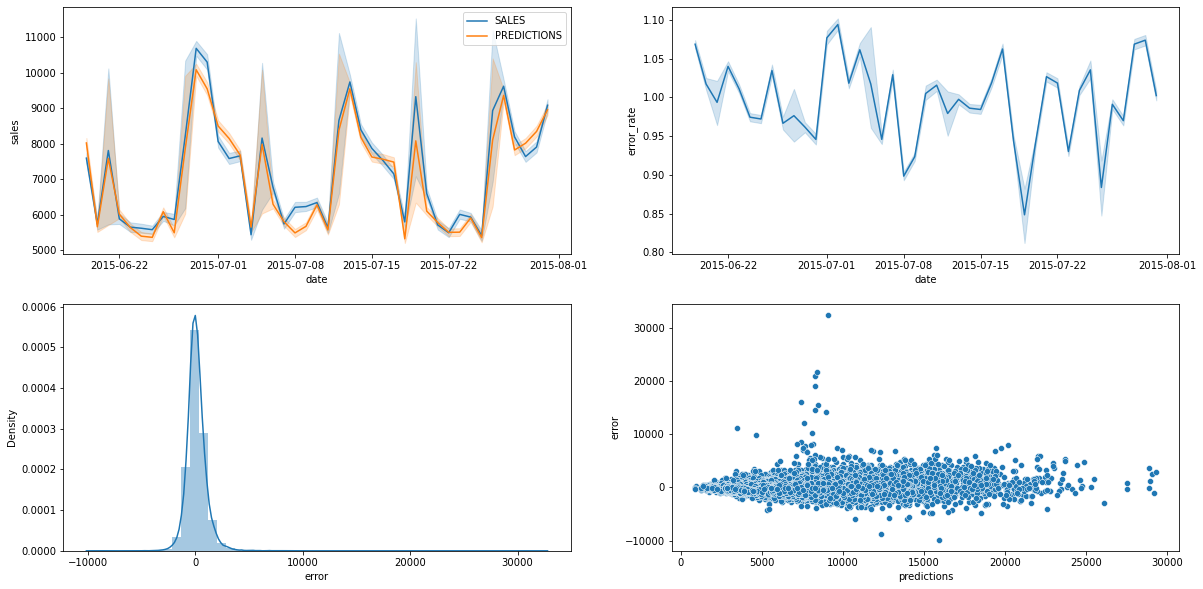

In [90]:
plt.figure(figsize = ( 20,10 ) )

plt.subplot( 2, 2, 1 )
sns.lineplot( x = 'date', y = 'sales', data = df9, label = 'SALES' )
sns.lineplot( x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x = 'date', y = 'error_rate', data = df9 )

plt.subplot( 2, 2, 3 )
sns.distplot( df9[ 'error' ] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

## 10.0 Deploy Model to Production

### 10.1 Rossmann Class

In [145]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

rs = RobustScaler()
mms = MinMaxScaler()
le = LabelEncoder()


class Rossmann( object ):
    def __init__( self ):
        self.competition_distance_scaler        = pickle.load( rs, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler      = pickle.load( rs, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler             = pickle.load( rs, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                        = pickle.load( mms, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler                  = pickle.load( le, open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/parameter/store_type_scaler.pkl', 'rb' ) )

    def data_cleaning( self, df1 ):    

        ### 1.1 Rename columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase,cols_old))

        df1.columns = cols_new

        ### 1.3 Data types

        df1['date'] = pd.to_datetime(df1['date'])

        ### 1.5 Fillout NA

        #competition_distance

        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

        #competition_open_since_year

        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis = 1)

        #promo2_since_week

        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis = 1)

        #promo2_since_year                                      

        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis = 1)

        #promo_interval

        month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

        df1['promo_interval'].fillna(0,inplace = True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis = 1)

        ### 1.6 Change types

        df1.dtypes

        #competition_open_since_month

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)

        #competition_open_since_year

        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

        #promo2_since_week

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)

        #promo2_since_year

        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
        
        return df1
    
    def feature_engineering( self, df2 ):    

    
        ### 2.3 Feature engineering

        #year
        df2['year'] = df2['date'].dt.year

        #month

        df2['month'] = df2['date'].dt.month

        #day

        df2['day'] = df2['date'].dt.day

        #week of year

        df2['weak_of_year'] = df2['date'].dt.weekofyear

        #year week

        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since

        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days ).astype( np.int64 )

        #promo since

        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply( lambda x:datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7).apply(lambda x: x.days).astype(np.int64)

        #assortment

        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        #state holiday

        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular day')

        ## 3.0 Filtering variables

        ### 3.1 Filtering rows

        df2 = df2[df2['open'] != 0]

        ### 3.2 Selection columns

        cols_drop = ['open','promo_interval','month_map']

        df2 = df2.drop(cols_drop,axis=1)
        
        return df2
    
    def data_preparation( self, df5 ):
    
        ### 5.2 Rescaling

        #competition_distance

        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        #year

        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        #competition_time_month

        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        #promo_time_week

        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )

        #### 5.3.1 Encoding

        #state_holiday - One Hot Encoding

        df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        
        #assortment - Ordinal Encoding

        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        #### 5.3.3 Nature transformation

        #day_of_week

        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2 * np.pi/12 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2 * np.pi/12 ) ) )

        #month

        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2 * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2 * np.pi/12 ) ) )

        #day

        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2 * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2 * np.pi/30 ) ) )

        #week_of_year

        df5['week_of_year_sin'] = df5['weak_of_year'].apply(lambda x: np.sin(x * ( 2 * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['weak_of_year'].apply(lambda x: np.cos(x * ( 2 * np.pi/52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                              'competition_open_since_month', 'competition_open_since_year', 'promo2',
                              'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                              'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
                              'day_sin', 'day_cos', 'week_of_year_cos','week_of_year_sin']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        pred = model.predict( test_data )
        
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient = 'records', date_format = 'iso' )

#### 10.2 API Handler

In [2]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model

model = pickle.load( open( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/model/model_rossmann.pkl', 'rb' ) )

app = Flask( __name__ )

@app.route( '/rossmann/predict', methods = [ 'POST' ] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
            if isinstance( test_json, dict ):
                test_raw = pd.DataFrame( test_json, index = [0] )
            else:
                test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
                
            pipeline = Rossmann()
            
            #data cleaning
            df1 = pipeline.data_cleaning( test_raw )
            
            #featuring engineering
            df2 = pipeline.feature_engineering( df1 )
            
            #data preparation
            df3 = pipeline.data_preparation( df2 )
            
            #prediction
            df_response = pipeline.get_prediction( model, test_raw, df3 )
            
            return df_response
    else:
            return Response( '{}', status = 200, mimetype = 'application/json' )

if __name__ == '__main__':
    app.run( '192.168.0.14' )

ModuleNotFoundError: No module named 'rossmann'

### 10.3 API Test

In [3]:
df10 = pd.read_csv( 'C:/Users/gabri/Repos/Rossmann-Store-Sales/Date/test.csv' )

In [10]:
df_test = pd.merge( df10, df_store_raw, how = 'left', on = 'Store' )

df_test = df_test[df_test['Store'].isin( [ 20, 22, 32 ] ) ]

df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis = 1 )

In [12]:
data = json.dumps( df_test.to_dict( orient = 'records' ) )

#url = 'http://192.168.0.14:5000/rossmann/predict'

url = 'https://model-prediction-rossmann.herokuapp.com/rossmann/predict'

header = { 'Content-type': 'application/json' }

data = data

r = requests.post( url, data = data, headers = header )
print( 'Status code {}'.format( r.status_code ) )

Status code 200


In [13]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [14]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store number {} will sell R${:,.2f} in the next 6 weeks'.format( d2.loc[ i,'store' ], d2.loc[ i, 'prediction' ] ) )

Store number 20 will sell R$277,706.87 in the next 6 weeks
Store number 22 will sell R$147,748.86 in the next 6 weeks
Store number 32 will sell R$189,876.24 in the next 6 weeks
